In [1]:
#libraries 
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import re
import hdbscan

In [2]:
#get dataset (subset of the original dataset with minhashing signatures)
data_minhashing=pd.read_csv("/Users/sararedaelli/Desktop/AMAZON REVIEWS/minhashing_results.csv")
#Let's take a sample of 10000 rows to test the code 
df=data_minhashing[0:10000]
df.shape
df.columns

Index(['signature', 'rating'], dtype='object')

In [3]:
#Prepare data for clustering:
#Convert integer to float
df['signature'] = df['signature'].apply(
    lambda s: np.array(re.findall(r'-?\d+', str(s)), dtype=int)
)

#Transform  df['signature'] in lists of length 100 
X = np.array(df['signature'].tolist())
y = df['rating'].values  # true labels

/var/folders/17/4ypkwf497x10dw9zl6kjtsg80000gn/T/ipykernel_22645/2156793347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signature'] = df['signature'].apply(


In [4]:
#check X and y shape 
print(X.shape)
print(y.shape)

(10000, 100)
(10000,)


## CLUSTERING 

# K-MEANS 

In [64]:
#RUN K-MEANS
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
Kmeans_clusters = kmeans.fit_predict(X)


In [65]:
#check clustering results 
Kmeans_clusters.shape
print(Kmeans_clusters[70:75])
print(np.unique(Kmeans_clusters))

[1 3 4 3 4]
[0 1 2 3 4]


## EVALUATION KMEANS

In [66]:
clusters=Kmeans_clusters+1  # shift to make clusters start at 1

In [67]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    db = davies_bouldin_score(X, clusters)
    return db

#Evaluate K-Means
db_Kmeans = DB(X, Kmeans_clusters)
print(f"Davies-Bouldin Index (DB): {db_Kmeans:.4f}")
    

Davies-Bouldin Index (DB): 2.9647


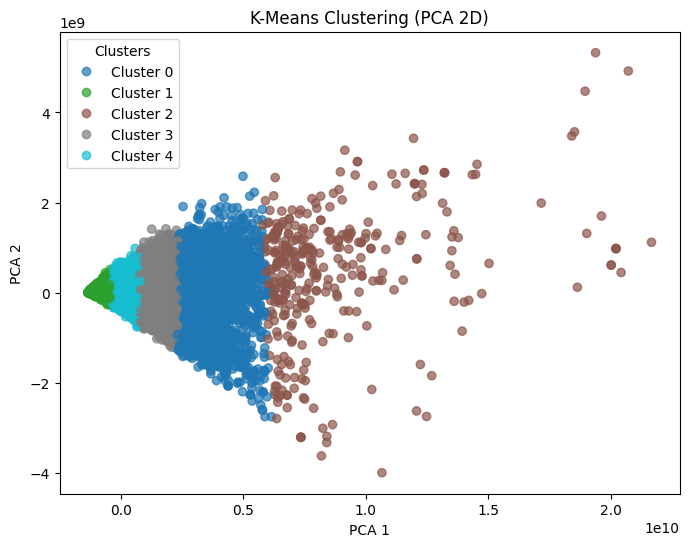

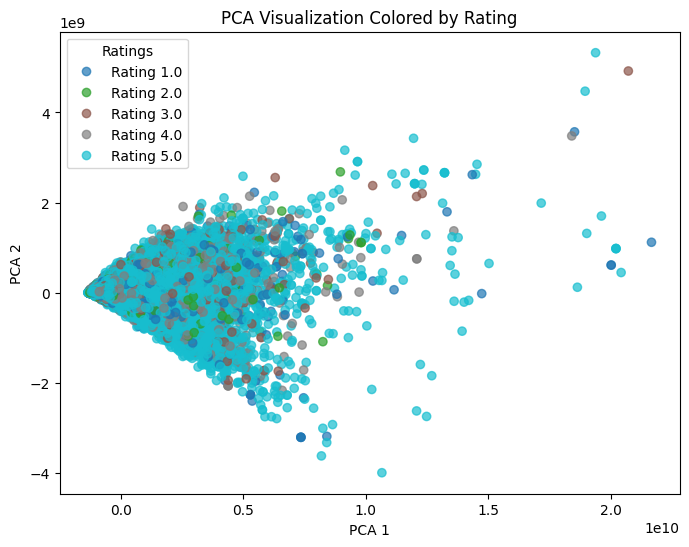

In [68]:
#PLOT IN 2D and COLOR by clusters 
# PCA to 2D
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

# Plot with legend
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], 
                      c=clusters, cmap='tab10', alpha=0.7)

# Add legend with cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(5)], title="Clusters")

plt.title("K-Means Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

#PLOT IN 2D and COLOR by ratings 
# Plot colored by rating
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], 
                      c=y, cmap='tab10', alpha=0.7)

# Add legend for unique ratings
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Rating {r}" for r in np.unique(y)], title="Ratings")

plt.title("PCA Visualization Colored by Rating")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

rating    1.0   2.0   3.0    4.0    5.0
cluster                                
1         303   154   329    835   3697
2        3670  3137  5002  11114  28166
3          38    12    21     42    242
4         883   532   884   2371   9666
5        2130  1406  2085   4865  18416


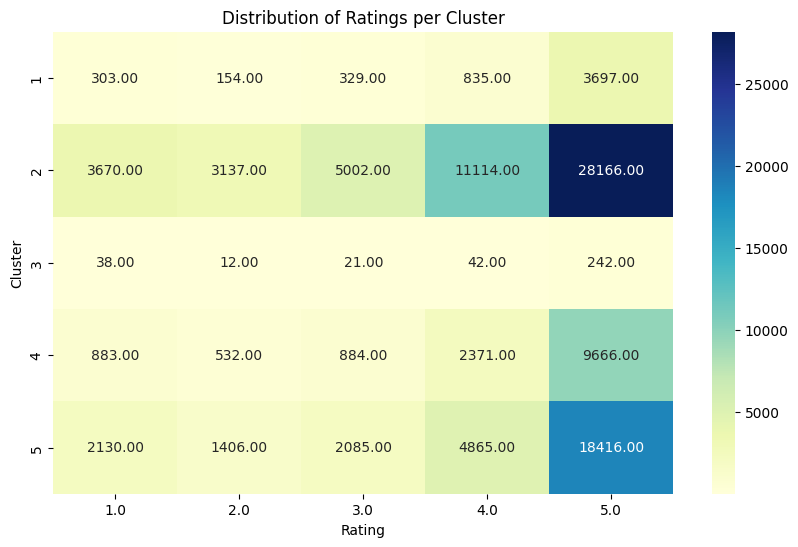

rating        1.0       2.0       3.0       4.0       5.0
cluster                                                  
1        0.043138  0.029384  0.039539  0.043429  0.061425
2        0.522494  0.598550  0.601130  0.578041  0.467975
3        0.005410  0.002290  0.002524  0.002184  0.004021
4        0.125712  0.101507  0.106237  0.123316  0.160599
5        0.303246  0.268269  0.250571  0.253030  0.305980


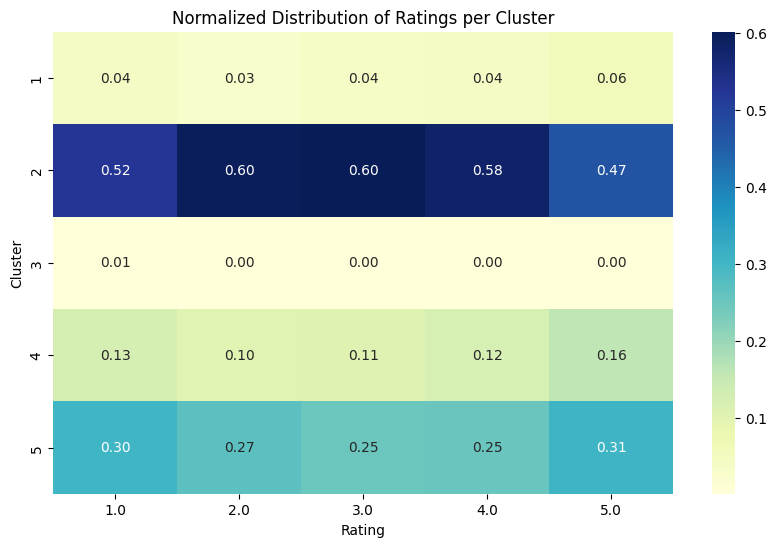

In [69]:

# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()


## DBSCAN

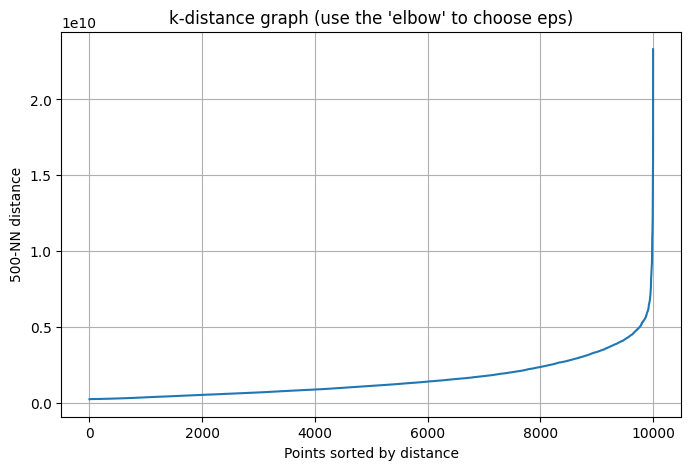

In [5]:
#DB-SCAN (standard)
#Two parameters to set: eps and min_points
minNpoints =500  # minimum number of points to form a dense region


#Find eps using k-distance plot

#Build the nearest neighbors model
neighbors = NearestNeighbors(n_neighbors=minNpoints)
#Compute for each point the distance to its minNpoints nearest neighbors
neighbors_fit = neighbors.fit(X)
#Consider the distances to the minNpoints-th nearest neighbors (last column)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances and make a plot (points/distances to minNpoints-th nearest neighbor)
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("k-distance graph (use the 'elbow' to choose eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{minNpoints}-NN distance")
plt.grid(True)
plt.show()

#Idea behind:
#Points in dense clusters have small minNpoints-NN distances
#Points in sparse areas or outliers have large minNpoints-NN distances

#After sorting, the graph shows an elbow where distances start increasing sharply
#The elbow indicates a suitable eps value for DBSCAN
#because points before the elbow are in dense areas
#and points after the elbow are in sparse areas or outliers

In [7]:
#Set eps based on visual inspection of the plot
eps = 0.5 

#Run DBSCAN 
dbscan = DBSCAN(eps=eps, min_samples=minNpoints)
Dbscan_clusters = dbscan.fit_predict(X)

In [8]:
#check clustering results 
Dbscan_clusters.shape
print(Dbscan_clusters[70:75])
print(np.unique(Dbscan_clusters))


[-1 -1 -1 -1 -1]
[-1]


## PCA + Dbscan 

In [9]:
#Dimensionality Reduction with PCA
pca = PCA(n_components=50, random_state=42)  # keep 50 principal components
X_pca = pca.fit_transform(X)
print(f"PCA reduced shape: {X_pca.shape}")
print(f"Explained variance ratio sum: {np.sum(pca.explained_variance_ratio_):.2f}")

#Run DBscan
Dbscan_clusters = dbscan.fit_predict(X_pca)

PCA reduced shape: (10000, 50)
Explained variance ratio sum: 0.78


In [72]:
#check clustering results 
Dbscan_clusters.shape
print(Dbscan_clusters[70:75])
print(np.unique(Dbscan_clusters))


[-1 -1 -1 -1 -1]
[-1]


## PCA + UMAP + DBSCAN

In [10]:
import umap
umap_model = umap.UMAP(
    n_neighbors=30,      # controls local vs global structure
    min_dist=0.0,        # tighter clusters
    n_components=15,      
    metric='euclidean',
    random_state=42
)

X_umap = umap_model.fit_transform(X_pca)

#Run DBscan
Dbscan_clusters = dbscan.fit_predict(X_umap)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## HDBSCAN

In [11]:
import hdbscan
#we do not need to find eps for HDBSCAN


HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=500,
    min_samples=minNpoints
)
Hdbscan_clusters = HDBSCAN.fit_predict(X_umap)


In [12]:
#check clustering results 
Hdbscan_clusters.shape
print(Dbscan_clusters[70:75])
print(np.unique(Dbscan_clusters))


[-1 -1 -1  1 -1]
[-1  0  1]


## EVALUATION DBSCAN

In [13]:
#clusters=Dbscan_clusters+1  # shift to make clusters start at 1
clusters=Hdbscan_clusters+1 

In [15]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    db = davies_bouldin_score(X, clusters)
    return db

#Evaluate DBSCAN
db_DBscan = DB(X, Hdbscan_clusters)
print(f"Davies-Bouldin Index (DB) for DBSCAN: {db_DBscan:.4f}")

Davies-Bouldin Index (DB) for DBSCAN: 2.3151


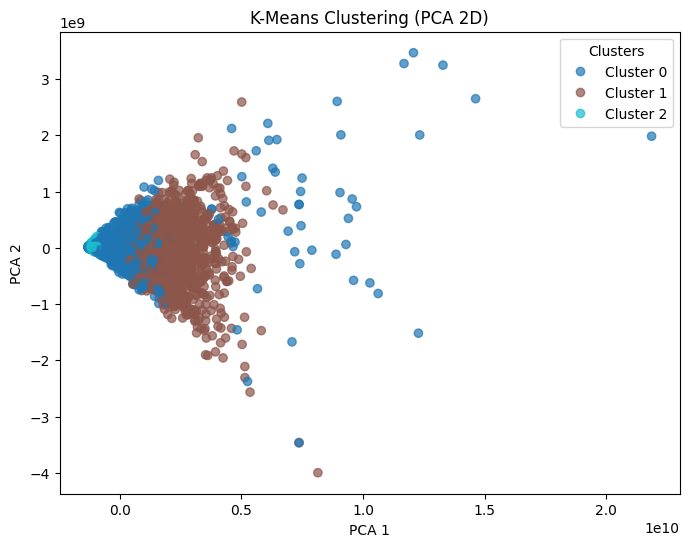

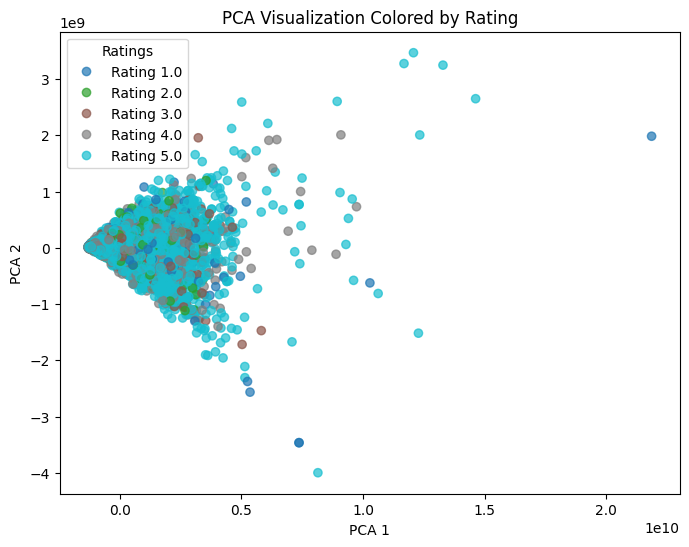

In [16]:
#PLOT IN 2D and COLOR by clusters 
# PCA to 2D
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

# Plot with legend
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], 
                      c=clusters, cmap='tab10', alpha=0.7)

# Add legend with cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in range(5)], title="Clusters")

plt.title("K-Means Clustering (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

#PLOT IN 2D and COLOR by ratings 
# Plot colored by rating
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], 
                      c=y, cmap='tab10', alpha=0.7)

# Add legend for unique ratings
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Rating {r}" for r in np.unique(y)], title="Ratings")

plt.title("PCA Visualization Colored by Rating")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

rating   1.0  2.0  3.0   4.0   5.0
cluster                           
0        728  571  866  2065  5736
1          0    0    0     0     4
2          0    0    0     0     3
3          0    3    0     0     0
4          0    0    0     3     0
5          0    0    0     0     7
6          0    0    0     0     3
7          0    0    0     0     4
8          0    0    0     0     4
9          0    0    0     0     3


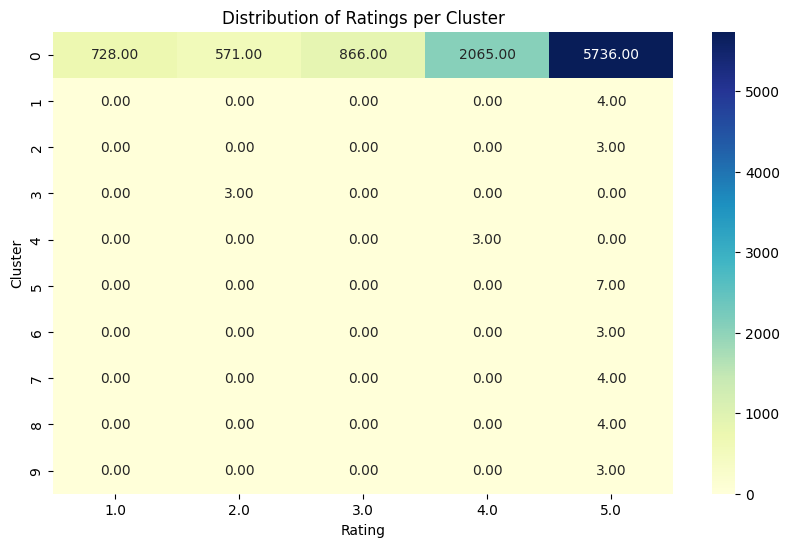

rating   1.0       2.0  3.0       4.0       5.0
cluster                                        
0        1.0  0.994774  1.0  0.998549  0.995142
1        0.0  0.000000  0.0  0.000000  0.000694
2        0.0  0.000000  0.0  0.000000  0.000520
3        0.0  0.005226  0.0  0.000000  0.000000
4        0.0  0.000000  0.0  0.001451  0.000000
5        0.0  0.000000  0.0  0.000000  0.001214
6        0.0  0.000000  0.0  0.000000  0.000520
7        0.0  0.000000  0.0  0.000000  0.000694
8        0.0  0.000000  0.0  0.000000  0.000694
9        0.0  0.000000  0.0  0.000000  0.000520


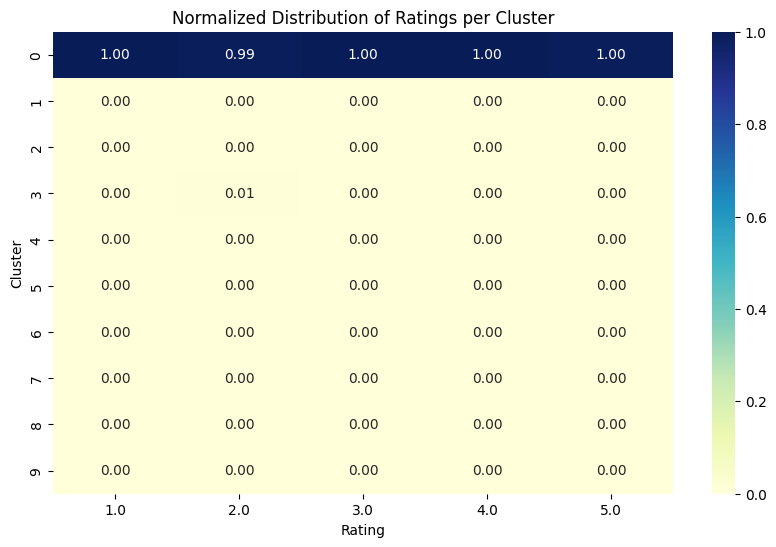

In [47]:
# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()